In [1]:
pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.0 MB/s eta 0:00:00


In [2]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora', transform=T.NormalizeFeatures())

# Check the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')


Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7


In [4]:
data = dataset[0]

print(data)
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000
Is undirected: True


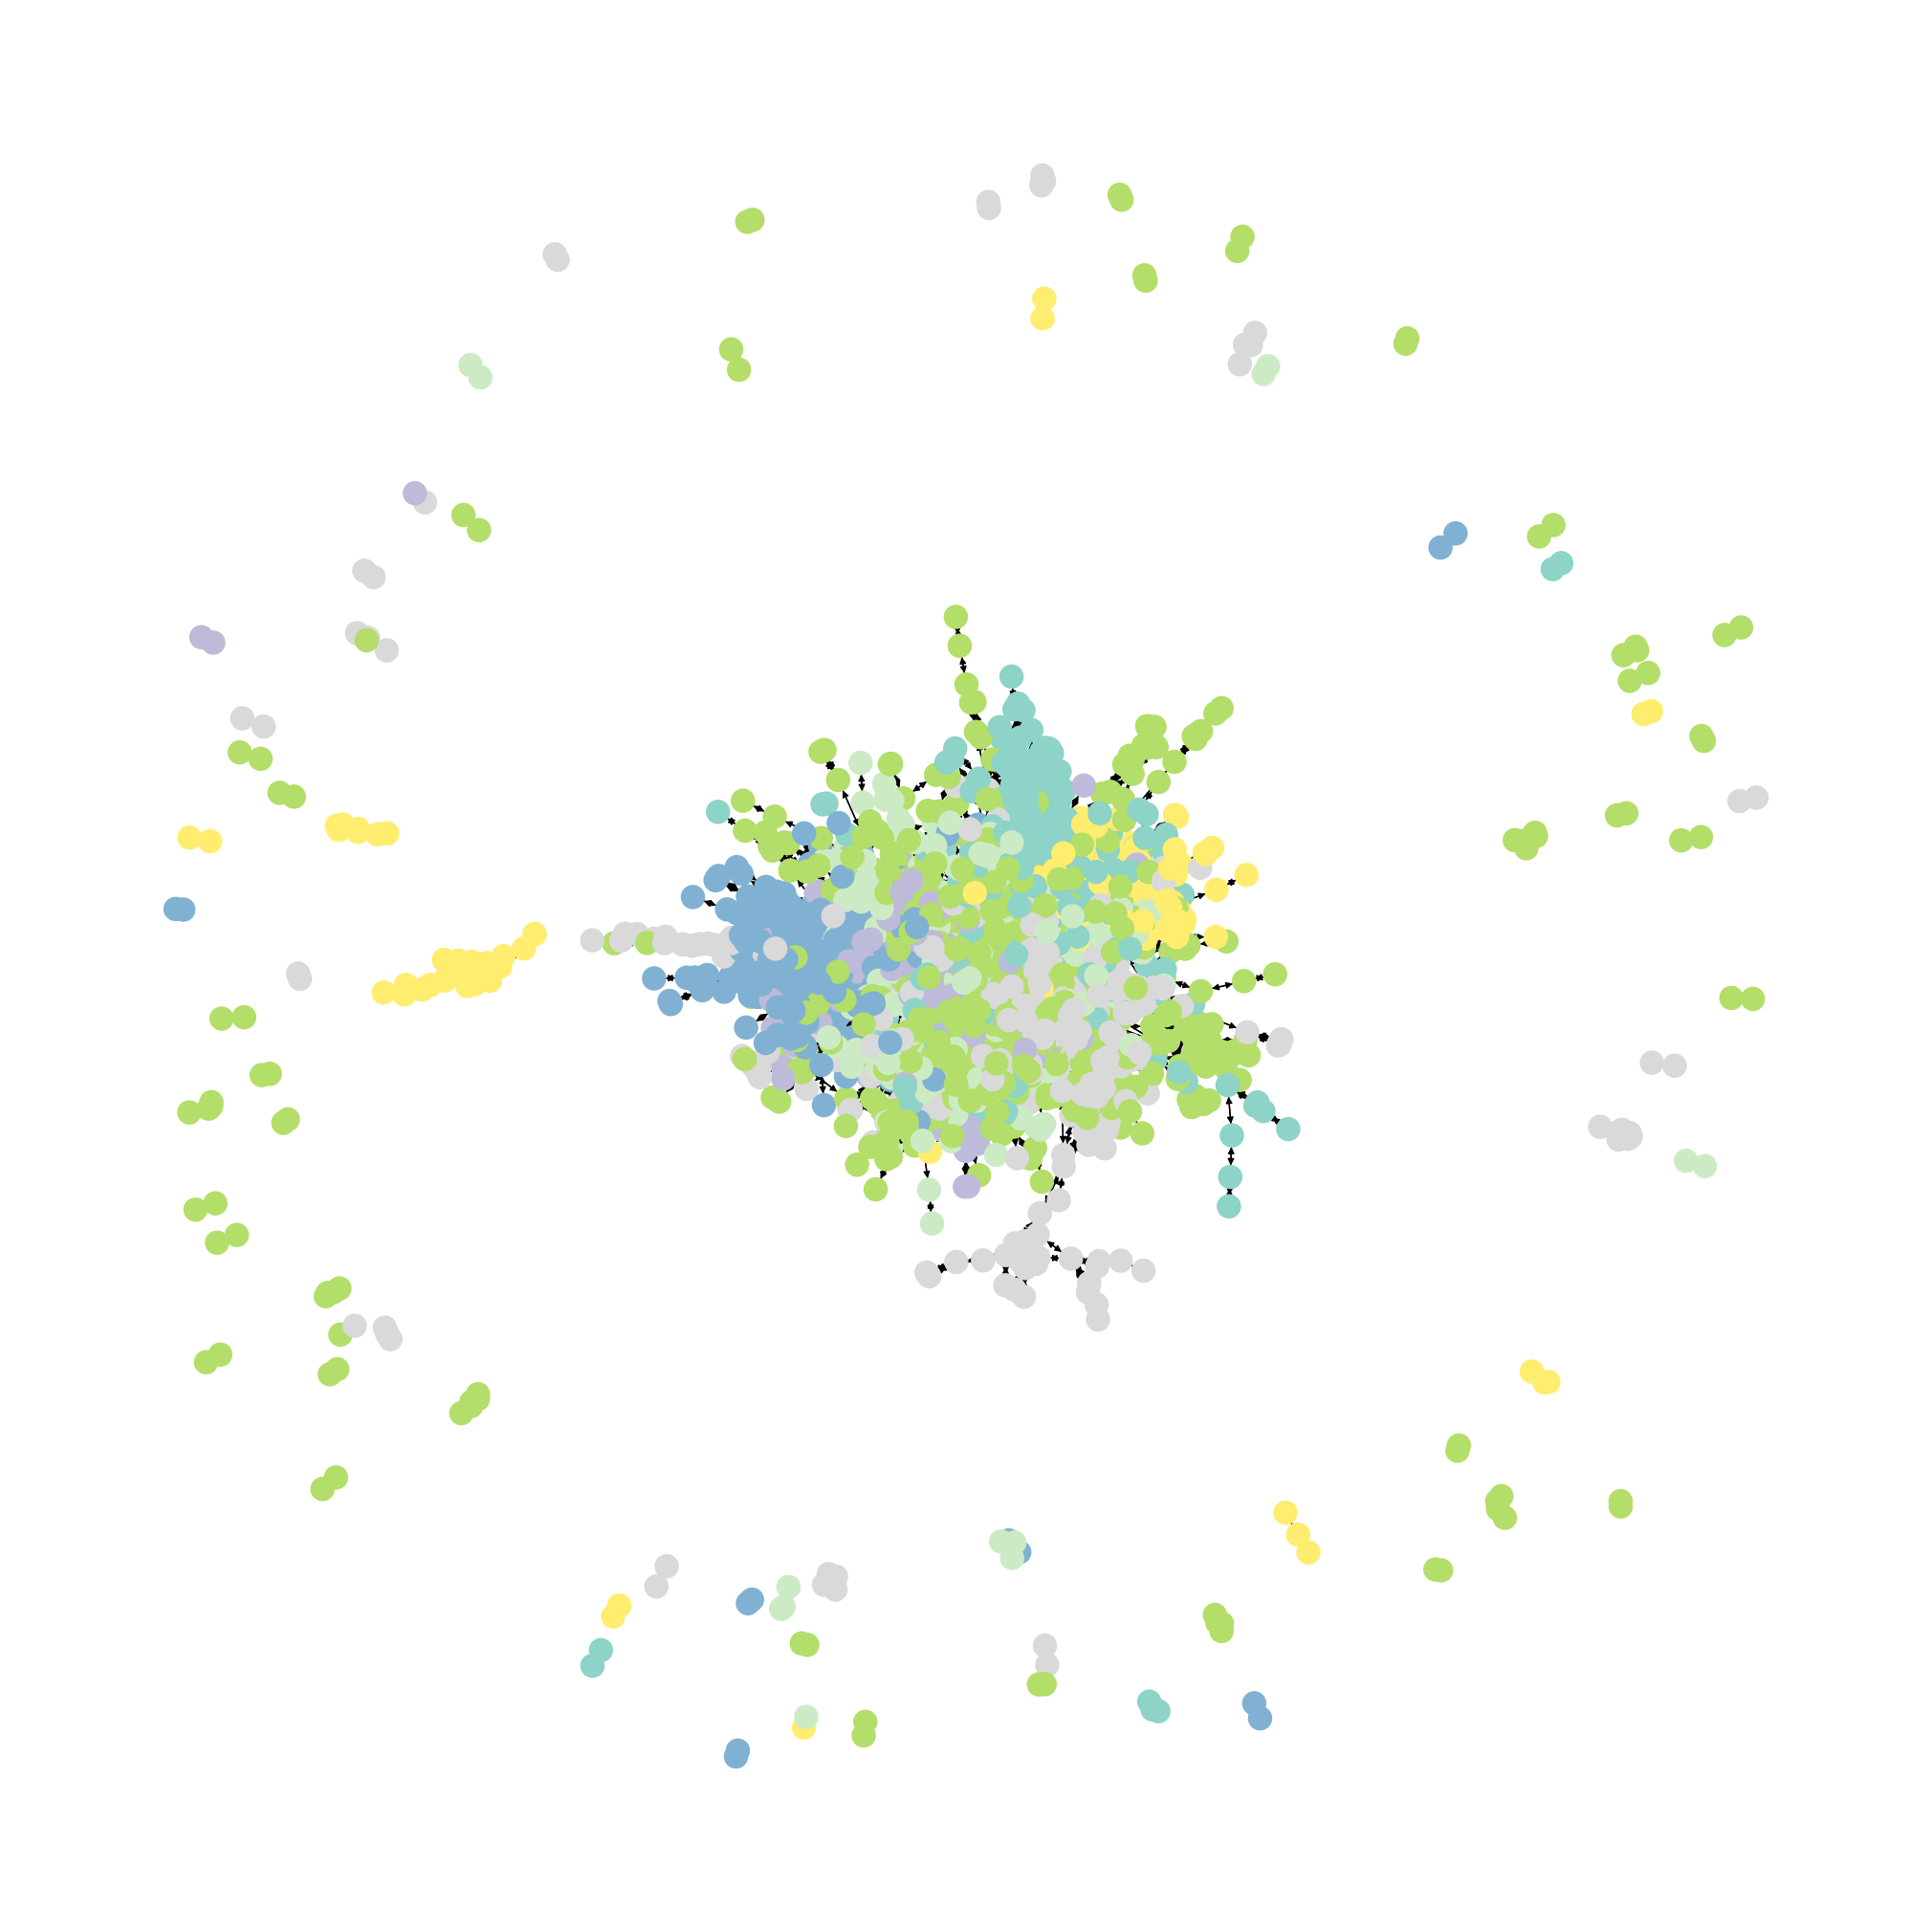

In [5]:
data = dataset[0]
G = to_networkx(data, node_attrs=['x'], edge_attrs=None)

plt.figure(figsize=(20, 20))
nx.draw(G, with_labels=False, node_color=data.y, cmap=plt.get_cmap('Set3'))
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p =0.5, training=self.training)

        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GCN()
print(model)


GCN(
  (conv1): GCNConv(1433, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 16)
  (conv4): GCNConv(16, 7)
)


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
data = dataset[0].to(device)
criterion = nn.CrossEntropyLoss()

def train_model(model, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        model.train()

        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():

          _, train_pred = model(data).max(dim=1)
          train_correct = int(train_pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
          train_acc = train_correct / int(data.train_mask.sum().item())

          _, val_pred = model(data).max(dim=1)
          val_correct = int(val_pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
          val_acc = val_correct / int(data.val_mask.sum().item())
          print(f'Epoch {epoch}/{num_epochs - 1}, '
                  f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    return model

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model = train_model(model, criterion, optimizer, num_epochs=25)


Epoch 0/24, Training Accuracy: 0.2500, Validation Accuracy: 0.1660
Epoch 1/24, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 2/24, Training Accuracy: 0.1429, Validation Accuracy: 0.1620
Epoch 3/24, Training Accuracy: 0.4929, Validation Accuracy: 0.3720
Epoch 4/24, Training Accuracy: 0.5357, Validation Accuracy: 0.3860
Epoch 5/24, Training Accuracy: 0.4857, Validation Accuracy: 0.3500
Epoch 6/24, Training Accuracy: 0.5000, Validation Accuracy: 0.4060
Epoch 7/24, Training Accuracy: 0.5929, Validation Accuracy: 0.4080
Epoch 8/24, Training Accuracy: 0.6071, Validation Accuracy: 0.4160
Epoch 9/24, Training Accuracy: 0.6714, Validation Accuracy: 0.4620
Epoch 10/24, Training Accuracy: 0.7143, Validation Accuracy: 0.5200
Epoch 11/24, Training Accuracy: 0.7357, Validation Accuracy: 0.5280
Epoch 12/24, Training Accuracy: 0.7500, Validation Accuracy: 0.5480
Epoch 13/24, Training Accuracy: 0.7929, Validation Accuracy: 0.6640
Epoch 14/24, Training Accuracy: 0.8357, Validation Accurac

In [8]:
model.eval()
_, pred = model(data).max(dim=1)
correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / int(data.test_mask.sum())
print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7630
